In [1]:
import numpy as np
from matplotlib import pyplot as plt
#from pygazeanalyser.edfreader import read_edf
from ANEMO import read_edf
import pickle
import os
from lmfit import  Model, Parameters

In [2]:
timeStr = '2017-09-28_115250'
observer = 'IP'
mode = 'enregistrement'

file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [3]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']

stim_tau = exp['stim_tau']
p = exp['p']

In [4]:
trial = 100
block = 0
trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']
trackertime_0 = trackertime[0]
TRIALID = data[trial_data]['events']['msg'][0][0]
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
fixations = data[trial_data]['events']['Efix']
saccades = data[trial_data]['events']['Esac']

start = TargetOn

TRIALID_s = TRIALID - start
StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start

# plot tracé

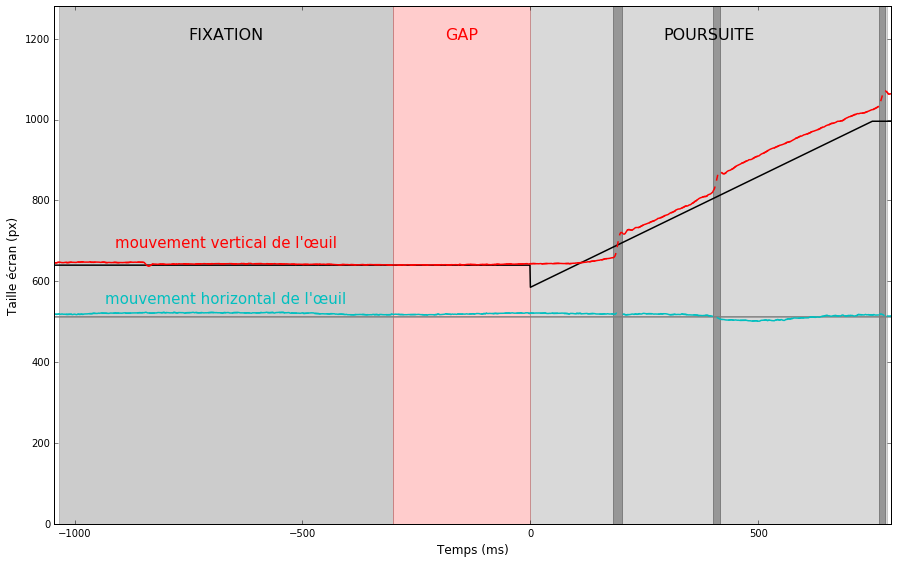

In [5]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/1.6180)))

##################################################
# TARGET
##################################################
dir_bool = p[trial, block, 0]*2 - 1
tps_mvt = TargetOff-TargetOn
Target_trial = []
x = screen_width_px/2


for t in range(len(trackertime)):
    if t < (TargetOn-trackertime_0) :
        x = screen_width_px/2
    elif t == (TargetOn-trackertime_0) :
        # la cible à t=0 recule de sa vitesse * latence=RashBass (ici mis en ms)
        x = x -(dir_bool * ((V_X/1000)*RashBass))
    elif (t > (TargetOn-trackertime_0) and t <= ((TargetOn-trackertime_0)+stim_tau*1000)) :
        x = x + (dir_bool*(V_X/1000))
    else :
        x = x
    Target_trial.append(x)

##################################################
# SUPPRESION DES SACCADES
##################################################
data_x_NAN = []
data_y_NAN = []
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            data_x_NAN.append('nan')
            data_y_NAN.append('nan')
            saccade = 'yes'
    if not saccade :
        data_x_NAN.append(data_x[x_data])
        data_y_NAN.append(data_y[x_data])
    saccade = None
            
##################################################           
            
axs.axis([StimulusOf_s-10, TargetOff_s+10, 0, 1280])
axs.plot(trackertime_s, np.ones(len(trackertime))*(screen_height_px/2), color='grey', linewidth=1.5)
axs.plot(trackertime_s, data_y, '--', color='c', linewidth=1.5)
axs.plot(trackertime_s, data_y_NAN, color='c', linewidth=1.5)

axs.plot(trackertime_s, Target_trial, color='k', linewidth=1.5)
axs.plot(trackertime_s, data_x, '--', color='r', linewidth=1.5)
axs.plot(trackertime_s, data_x_NAN, color='r', linewidth=1.5)


axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)



axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Taille écran (px)', fontsize=12)
axs.axis([StimulusOn_s-10, TargetOff_s+10, 0, 1280])

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 1200, "FIXATION", color='k', fontsize=16, ha='center')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 1200, "GAP", color='r', fontsize=16, ha='center')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 1200, "POURSUITE", color='k', fontsize=16, ha='center')

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 685, "mouvement vertical de l'œuil", color='r', fontsize=15, ha='center')
axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 545, "mouvement horizontal de l'œuil", color='c', fontsize=15, ha='center')


#for f in range(len(fixations)) :
#    axs.axvspan(fixations[f][0]-start, fixations[f][1]-start, color='r', alpha=0.1)
for s in range(len(saccades)) :
    axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.3)

plt.show()

# plot vitesse

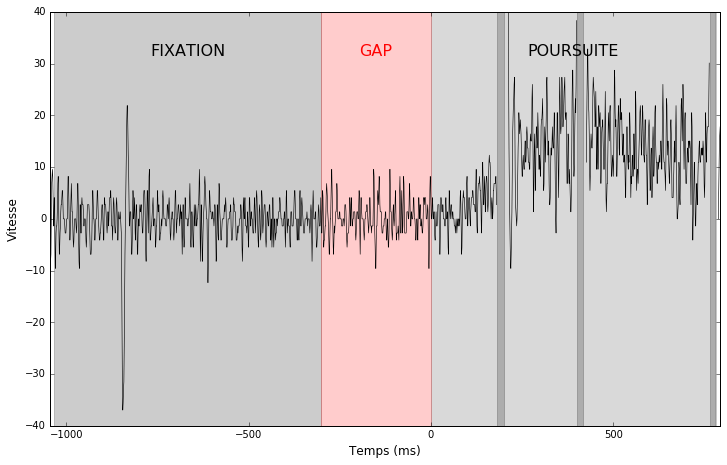

In [6]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width)/1.6180))


gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

##################################################
# SUPPRESION SACCADES
##################################################
gradient_deg_NAN = []
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+10)) :
            gradient_deg_NAN.append(np.nan)#gradient_deg_NAN[x_data-1])#'nan')
            saccade = 'yes'
    if not saccade :
        gradient_deg_NAN.append(gradient_deg[x_data])
    saccade = None
##################################################
    
debut  = TargetOn - trackertime_0 # TargetOn - temps_0


axs.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])

axs.plot(trackertime_s, gradient_deg_NAN, 'k', linewidth=0.6)

axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
for s in range(len(saccades)) :
    axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 31, "FIXATION", color='k', fontsize=16, ha='center', va='bottom')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='r', fontsize=16, ha='center', va='bottom')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 31, "POURSUITE", color='k', fontsize=16, ha='center', va='bottom')

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)

plt.show()

# plot vitesse

In [7]:
def exponentiel (x, tau=0.013, maxi=10., start_anti=500., v_anti=0.1, latence=1000., bino=0) :
    '''
    tau -- courbe
    maxi -- maximum
    latence -- tps où commence le mvt
    bino -- binomial
    
    start_anti = debut de l'anticipation
    v_anti =  vitesse de l'anticipation
    ''' 
    
    time = np.arange(len(x))
    vitesse = []
                
    for t in range(len(time)):
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence))))
        else :

            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append((bino*2-1)*(time[t]-start_anti)*v_anti)
                    x = (bino*2-1)*(time[t]-start_anti)*v_anti
                else :
                    vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
    return vitesse

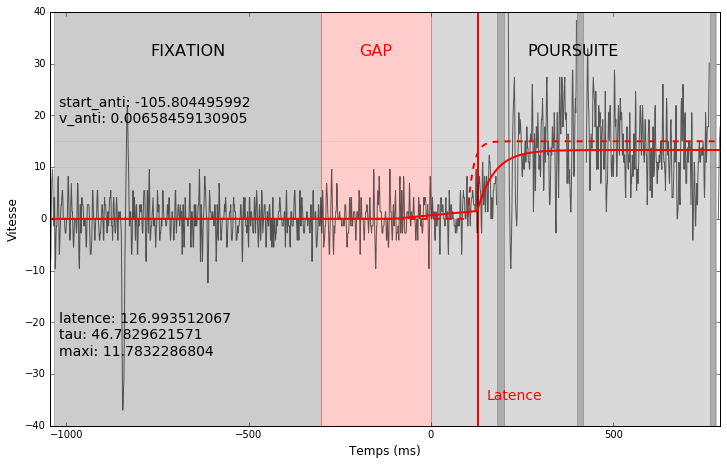

[[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # function evals   = 136
    # data points      = 1898
    # variables        = 5
    chi-square         = 55275.487
    reduced chi-square = 29.200
    Akaike info crit   = 6409.162
    Bayesian info crit = 6436.905
[[Variables]]
    tau:          46.7829621 +/- 11.00401 (23.52%) (init= 15)
    maxi:         11.7832286 +/- 0.746059 (6.33%) (init= 15)
    latence:      1219.99351 +/- 6.926112 (0.57%) (init= 1193)
    start_anti:   987.195504 +/- 107.9687 (10.94%) (init= 993)
    v_anti:       0.00658459 +/- 0.005297 (80.45%) (init= 0)
    bino:         1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(start_anti, v_anti)        =  0.867 
    C(maxi, v_anti)              = -0.820 
    C(tau, latence)              = -0.627 
    C(maxi, start_anti)          = -0.473 
    C(maxi, latence)             = -0.430 
    C(latence, v_anti)           =  0.351 
    C(latence, start_anti)       =  0.202 
    C(tau, maxi)  

In [8]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width)/1.6180))

gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

##################################################
# SUPPRESSION DES SACCADES
##################################################
gradient_deg_NAN = []
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+10)) :
            gradient_deg_NAN.append(np.nan)#gradient_deg_NAN[x_data-1])#'nan')
            saccade = 'yes'
    if not saccade :
        gradient_deg_NAN.append(gradient_deg[x_data])
    saccade = None        
##################################################
        
# FIT
model = Model(exponentiel)
bino=p[trial, block, 0]
params = Parameters()

params.add('tau', value=15., min=13., max=70.)#, vary=False)
params.add('maxi', value=15., min=10., max=40.)#, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0+50, max=len(trackertime))
params.add('start_anti', value=TargetOn-trackertime_0-100, min=StimulusOf-trackertime_0+100, max=TargetOn-trackertime_0)
params.add('v_anti', value=0., min=-1., max=1.)
params.add('bino', value=bino, min=0, max=1, vary=False)

#result_deg = model.fit(new_gradient_deg, params, x=new_time)
result_deg = model.fit(gradient_deg_NAN, params, x=trackertime, fit_kws={'nan_policy': 'omit'})

debut  = TargetOn - trackertime_0 # TargetOn - temps_0


axs.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])


axs.plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
axs.plot(trackertime_s, result_deg.init_fit, 'r--', linewidth=2)
axs.plot(trackertime_s, result_deg.best_fit, color='r', linewidth=2)
axs.plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*15, color='k', linewidth=0.2, alpha=0.2)
axs.plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*10, color='k', linewidth=0.2, alpha=0.2)


axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
for s in range(len(saccades)) :
    axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)
    
start_anti = result_deg.values['start_anti']-debut
v_anti = result_deg.values['v_anti']
latence = result_deg.values['latence']-debut
tau = result_deg.values['tau']
maxi = result_deg.values['maxi']


axs.bar(latence, 80, bottom=-40, color='r', width=6, linewidth=0)

       
axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 31, "FIXATION", color='k', fontsize=16, ha='center', va='bottom')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='r', fontsize=16, ha='center', va='bottom')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 31, "POURSUITE", color='k', fontsize=16, ha='center', va='bottom')
axs.text(latence+25, -35, "Latence", color='r', fontsize=14)#,  weight='bold')
axs.text(StimulusOn_s+15, 18, "start_anti: %s \nv_anti: %s"%(start_anti, v_anti), color='k', fontsize=14, va='bottom')
axs.text(StimulusOn_s+15, -18, "latence: %s \ntau: %s \nmaxi: %s"%(latence, tau, maxi), color='k', fontsize=14, va='top')

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)
plt.show()
print(result_deg.fit_report())